In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from sklearn.decomposition import PCA
from helper_funcs import *

/mmfs1/data/liacz/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# data_latent_vec = np.load(os.path.expanduser('~/Documents/Bilingualism_CVAE/data/latent_vecs10.npz')) # Load latent representations
# list(data_latent_vec.keys())# Split dictionary into separate variables
# salient_vec_BRAIN = data_latent_vec['salient_vec_BRAIN']
# background_vec_BRAIN = data_latent_vec['background_vec_BRAIN']
# vae_vec_BRAIN = data_latent_vec['vae_vec_BRAIN']

In [3]:
salient_vec_BRAIN = np.load(os.path.expanduser('~/Documents/Bilingualism_CVAE/data/latent_vecs10_s.npz'))['salient_vec_BRAIN']
background_vec_BRAIN = np.load(os.path.expanduser('~/Documents/Bilingualism_CVAE/data/latent_vecs10_z.npz'))['background_vec_BRAIN']
vae_vec_BRAIN = np.load(os.path.expanduser('~/Documents/Bilingualism_CVAE/data/latent_vecs10_vae.npz'))['vae_vec_BRAIN']
print(len(salient_vec_BRAIN))
print(len(background_vec_BRAIN))
print(len(vae_vec_BRAIN))

10
10
10


In [4]:
print(salient_vec_BRAIN.shape)
print(background_vec_BRAIN.shape)
print(vae_vec_BRAIN.shape)

(10, 1747, 16)
(10, 1747, 16)
(10, 1747, 32)


In [5]:
def data2cmat(data):
    return np.array([squareform(pdist(data[s,:,:],metric='euclidean')) for s in range(data.shape[0])])

In [6]:
# Bar plot function
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=False,do_one_sample_stars=True):
    
    import seaborn as sns
    from scipy.stats import ttest_1samp
    from scipy.stats import ttest_ind as ttest
    
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1
    


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))

    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = ['VAE','BG','SL']
    plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight)
    
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(3)])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = ['VAE','BG','SL']
        for i in range(c):
            these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
            xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = ['VAE','BG','SL']

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
            max_y = new_y[-1] + comp_idx*.05
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
    ylim = plt.ylim()
    plt.ylim(np.array(ylim)*(1,1.1))
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)

In [7]:
# Make (dis)similarity matrices
cmat_salient_vec_BRAIN = data2cmat(salient_vec_BRAIN)
cmat_background_vec_BRAIN = data2cmat(background_vec_BRAIN)
cmat_vae_vec_BRAIN = data2cmat(vae_vec_BRAIN)

In [8]:
cmat_salient_vec_BRAIN.shape

(10, 1747, 1747)

In [9]:
df = pd.read_csv(os.path.expanduser('~/Documents/Bilingualism_CVAE/data/legend.csv'))
len(df)

1747

In [10]:
# df = df[(df.ds=='Hernandez')]

In [11]:
# df = df[(df.ds=='ds1747')]

In [12]:
df['scanner'].value_counts()

Siemens Prisma        724
Siemens Prisma dev    571
Hernandez             360
Erlangen               92
Name: scanner, dtype: int64

In [13]:
indir = '/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/array_brains'
BRAIN_data = np.load(os.path.join(indir, "arr_combine/BRAIN_data.npy"))
BRAIN_subs = np.load(os.path.join(indir, "arr_combine/BRAIN_subs.npy"))
BRAIN_ds = np.load(os.path.join(indir, "arr_combine/BRAIN_ds.npy"))
legend_subs= df['ds_par_id']
BRAIN_ds_subs = [BRAIN_ds[i]+'_'+BRAIN_subs[i] for i in range(0,len(BRAIN_subs))]

BRAIN_subs.shape

(1747,)

In [14]:
BRAIN_ds_subs_pd = pd.DataFrame(BRAIN_ds_subs, columns = ['ds_par_id'])
BRAIN_ds_subs_pd['index'] = range(len(BRAIN_ds_subs_pd.iloc[:,0]))
BRAIN_ds_subs_pd

,ds_par_id,index
0,Hernandez_WL_052.mgz,0
1,Hernandez_271ES.mgz,1
2,Hernandez_PI_028.mgz,2
3,Hernandez_71_E.mgz,3
4,Hernandez_WL_002.mgz,4
...,...,...
1742,HCPdev_HCD2055237_V1_MR,1742
1743,HCPdev_HCD0232223_V1_MR,1743
1744,HCPdev_HCD0392649_V1_MR,1744
1745,HCPdev_HCD0197348_V1_MR,1745


In [70]:
df_sort = pd.merge(df, BRAIN_ds_subs_pd, how = 'right', on ='ds_par_id').sort_values(by=['index'])
df_sort.drop_duplicates(inplace=True)

In [71]:
# df_sort = df_sort[df_sort.ds=='ds1747']

In [64]:
df_sort

,participant_id,bilingualism,age,sex,aoa_group,num_lan,sec_lan_proficiency,ds,scanner,aoa,sec_lan_exposure,ds_par_id,index
0,WL_052.mgz,0.0,24.000000,F,NaN,NaN,NaN,Hernandez,Hernandez,NaN,NaN,Hernandez_WL_052.mgz,0
1,271ES.mgz,1.0,20.000000,M,EB,NaN,0.650000,Hernandez,Hernandez,5.0,NaN,Hernandez_271ES.mgz,1
2,PI_028.mgz,1.0,22.000000,F,LB,NaN,0.746276,Hernandez,Hernandez,8.0,NaN,Hernandez_PI_028.mgz,2
3,71_E.mgz,1.0,22.000000,F,EB,NaN,0.500000,Hernandez,Hernandez,4.0,NaN,Hernandez_71_E.mgz,3
4,WL_002.mgz,0.0,20.000000,F,NaN,NaN,NaN,Hernandez,Hernandez,NaN,NaN,Hernandez_WL_002.mgz,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,HCD2055237_V1_MR,1.0,8.916667,F,EB,2.0,0.733333,HCPdev,Siemens Prisma dev,5.0,30.0,HCPdev_HCD2055237_V1_MR,1742
1743,HCD0232223_V1_MR,0.0,13.750000,F,NaN,1.0,NaN,HCPdev,Siemens Prisma dev,NaN,NaN,HCPdev_HCD0232223_V1_MR,1743
1744,HCD0392649_V1_MR,1.0,16.750000,M,EB,2.0,1.000000,HCPdev,Siemens Prisma dev,2.0,60.0,HCPdev_HCD0392649_V1_MR,1744
1745,HCD0197348_V1_MR,0.0,11.666667,M,NaN,1.0,NaN,HCPdev,Siemens Prisma dev,NaN,NaN,HCPdev_HCD0197348_V1_MR,1745


In [72]:
df_sort['bilingualism']=pd.to_numeric(df_sort.bilingualism)
df_sort['num_lan']=pd.to_numeric(df_sort.num_lan)
df_sort['age']=pd.to_numeric(df_sort.age)
df_sort['aoa']=pd.to_numeric(df_sort.aoa)
df_sort['sec_lan_proficiency']=pd.to_numeric(df_sort.sec_lan_proficiency)
df_sort['sec_lan_exposure']=pd.to_numeric(df_sort.sec_lan_exposure)

# df_sort = df_sort[df_sort.ds == 'Hernandez']

In [73]:
df_sort

,participant_id,bilingualism,age,sex,aoa_group,num_lan,sec_lan_proficiency,ds,scanner,aoa,sec_lan_exposure,ds_par_id,index
0,WL_052.mgz,0.0,24.000000,F,NaN,NaN,NaN,Hernandez,Hernandez,NaN,NaN,Hernandez_WL_052.mgz,0
1,271ES.mgz,1.0,20.000000,M,EB,NaN,0.650000,Hernandez,Hernandez,5.0,NaN,Hernandez_271ES.mgz,1
2,PI_028.mgz,1.0,22.000000,F,LB,NaN,0.746276,Hernandez,Hernandez,8.0,NaN,Hernandez_PI_028.mgz,2
3,71_E.mgz,1.0,22.000000,F,EB,NaN,0.500000,Hernandez,Hernandez,4.0,NaN,Hernandez_71_E.mgz,3
4,WL_002.mgz,0.0,20.000000,F,NaN,NaN,NaN,Hernandez,Hernandez,NaN,NaN,Hernandez_WL_002.mgz,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,HCD2055237_V1_MR,1.0,8.916667,F,EB,2.0,0.733333,HCPdev,Siemens Prisma dev,5.0,30.0,HCPdev_HCD2055237_V1_MR,1742
1743,HCD0232223_V1_MR,0.0,13.750000,F,NaN,1.0,NaN,HCPdev,Siemens Prisma dev,NaN,NaN,HCPdev_HCD0232223_V1_MR,1743
1744,HCD0392649_V1_MR,1.0,16.750000,M,EB,2.0,1.000000,HCPdev,Siemens Prisma dev,2.0,60.0,HCPdev_HCD0392649_V1_MR,1744
1745,HCD0197348_V1_MR,0.0,11.666667,M,NaN,1.0,NaN,HCPdev,Siemens Prisma dev,NaN,NaN,HCPdev_HCD0197348_V1_MR,1745


In [74]:
patients = df_sort['bilingualism'].values==1.0
controls = df_sort['bilingualism'].values==0.0

In [75]:
def make_RDM(inVec, data_scale='ratio', metric='euclidean'):
    vec = inVec
    def fun(u,v):
        const = 0 if u[0] == v[0] else 1
        return np.sqrt(const**2)
    if data_scale=='ratio':
        vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten()))
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose()
    if data_scale=='ordinal':
        mat = squareform(pdist(vec, fun).transpose())
#         mat[mat!=0]=1 # Make into zeros and ones
    if data_scale=='ratio':
        mat = squareform(pdist(vec,metric=metric).transpose())
    return mat

In [79]:
# BRAIN MAKE MODELS 
# plt.figure(figsize=(15,15))
default_keys = ['sec_lan_proficiency','sec_lan_exposure', 'aoa', 'aoa_group',  'age','sex', 'scanner']
# default_keys = ['sec_lan_proficiency', 'aoa', 'age',  'sex', 'scanner']

# default_keys = ['age', 'sex', 'scanner']

# scales_ = ['ratio', 'ordinal','ordinal']
scales_ = ['ratio','ratio','ratio', 'ordinal','ratio','ordinal','ordinal']
# scales_ = ['ratio', 'ratio','ratio', 'ordinal','ordinal']



model_rdms = dict()
model_idxs = dict()
for i in range(len(default_keys)):
    print(default_keys[i])
    inVec = df_sort[default_keys[i]].values[patients]
    idx_all = df_sort['index'].values[patients]
#     inVec = df_sort[default_keys[i]].to_numpy() 
#     idx_all = df_sort['index'].to_numpy() 
    idx = idx_all[~pd.isna(inVec)]
    inVec = inVec[~pd.isna(inVec)]
    this_rdm = make_RDM(inVec, data_scale=scales_[i])
#     print(len(idx))
    model_rdms.update({default_keys[i] : this_rdm})
    model_idxs.update({default_keys[i] : idx})

sec_lan_proficiency
sec_lan_exposure
aoa
aoa_group
age
sex
scanner


In [80]:
model_rdms['sec_lan_proficiency'].shape

(653, 653)

In [81]:
def slice_cmat(data,idx):
#     mat = data[patients,:][:,patients]
    mat = data[idx,:][:,idx]
    return mat

In [82]:
def fit_rsa(data,key):
    corr = scipy.stats.stats.kendalltau
    r = np.array([corr(get_triu(slice_cmat(data[i,:,:],model_idxs[key])),get_triu(model_rdms[key]))[0] for i in range(10)])
    r = np.arctan(r)
    return r

In [83]:
data = [cmat_vae_vec_BRAIN, cmat_background_vec_BRAIN, cmat_salient_vec_BRAIN]

rsa_results = dict()
for key in default_keys:
    print(key)
    res = np.array([fit_rsa(datum,key) for datum in data]).transpose()
    rsa_results.update({key : res})

sec_lan_proficiency
sec_lan_exposure
aoa
aoa_group
age
sex
scanner


In [84]:
for datum in data:
    print(datum[0][0])

[0.         5.88435106 6.86007386 ... 7.06686845 7.89745915 7.9476199 ]
[0.         3.06295065 3.53557362 ... 5.33068836 4.11154466 5.25800361]
[0.         2.23855374 2.79479033 ... 4.62817198 2.09469966 3.673212  ]


In [85]:
# corr = scipy.stats.stats.kendalltau
# corr(df_sort['aoa'], df_sort['aoa_group'], nan_policy='omit')

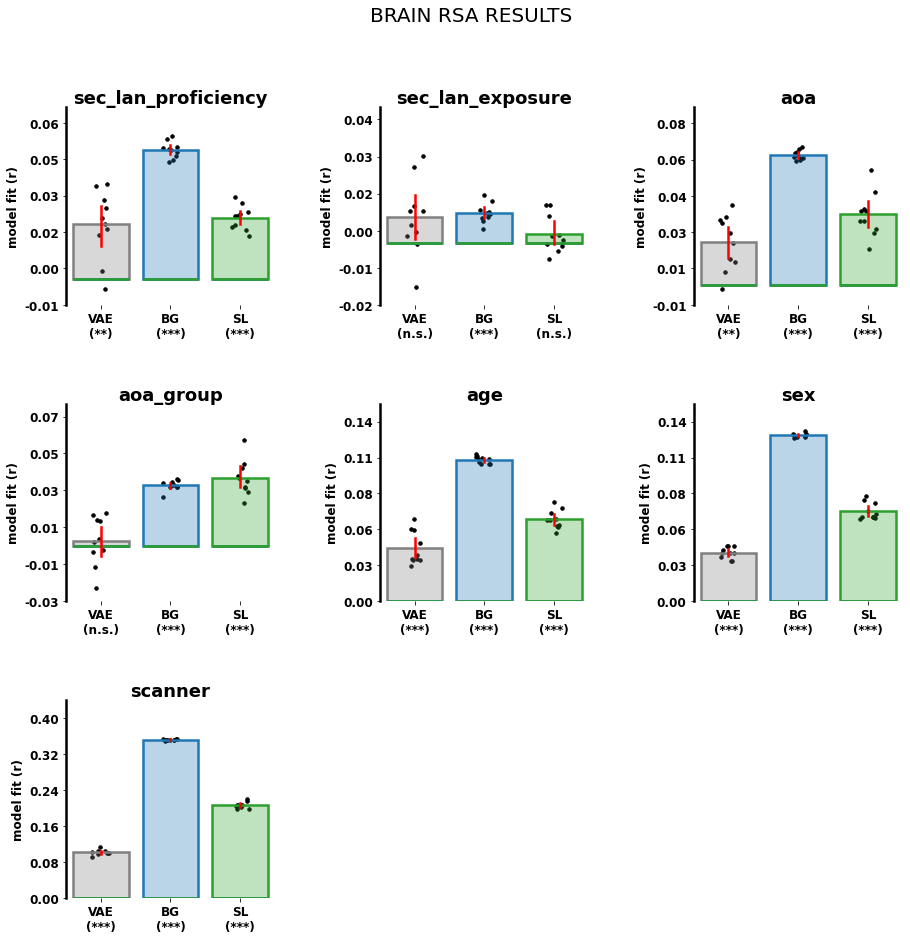

In [90]:
keys = ['sec_lan_proficiency', 'sec_lan_exposure', 'aoa','aoa_group', 'age','sex','scanner']
titles = ['sec_lan_proficiency', 'sec_lan_exposure', 'aoa','aoa_group', 'age','sex','scanner']

# keys = ['age','sex', 'scanner']
# titles = ['age','sex', 'scanner']

# keys = ['sec_lan_proficiency','aoa', 'age','sex']
# titles = ['sec_lan_proficiency','aoa',  'age','sex']


ncols = 3
nrows = int(np.ceil(len(keys)/2))

plt.figure(figsize=np.array((ncols,nrows))*5)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_results,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=titles[i])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('BRAIN RSA RESULTS',fontsize=20,y=.95);

In [87]:
cmat_vae_vec_BRAIN.shape

(10, 1747, 1747)

In [88]:
default_keys

['sec_lan_proficiency',
 'sec_lan_exposure',
 'aoa',
 'aoa_group',
 'age',
 'sex',
 'scanner']

In [91]:
#only 10 samples, more samples we use, more sensitive -- 10 is the optimal 
# https://www.jstor.org/stable/24700283

## analysis

In [52]:
df_sort

,participant_id,bilingualism,age,sex,aoa_group,num_lan,sec_lan_proficiency,ds,scanner,aoa,sec_lan_exposure,ds_par_id,index
0,sub-3891,1.0,26.000000,F,EB,2.0,1.000000,ds1747,Erlangen,NaN,NaN,ds1747_sub-3891,0
1,sub-2975,0.0,21.000000,F,NaN,3.0,NaN,ds1747,Erlangen,NaN,NaN,ds1747_sub-2975,1
2,sub-3884,0.0,21.000000,M,NaN,2.0,NaN,ds1747,Erlangen,NaN,NaN,ds1747_sub-3884,2
3,sub-3925,0.0,18.000000,F,NaN,2.0,NaN,ds1747,Erlangen,NaN,NaN,ds1747_sub-3925,3
4,sub-3967,1.0,29.000000,M,EB,3.0,0.900000,ds1747,Erlangen,NaN,NaN,ds1747_sub-3967,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,HCD2055237_V1_MR,1.0,8.916667,F,EB,2.0,0.733333,HCPdev,Siemens Prisma dev,5.0,30.0,HCPdev_HCD2055237_V1_MR,2132
2133,HCD0232223_V1_MR,0.0,13.750000,F,NaN,1.0,NaN,HCPdev,Siemens Prisma dev,NaN,NaN,HCPdev_HCD0232223_V1_MR,2133
2134,HCD0392649_V1_MR,1.0,16.750000,M,EB,2.0,1.000000,HCPdev,Siemens Prisma dev,2.0,60.0,HCPdev_HCD0392649_V1_MR,2134
2135,HCD0197348_V1_MR,0.0,11.666667,M,NaN,1.0,NaN,HCPdev,Siemens Prisma dev,NaN,NaN,HCPdev_HCD0197348_V1_MR,2135


In [53]:
df_sort.bilingualism.value_counts()

0.0    1499
1.0     638
Name: bilingualism, dtype: int64

In [54]:
df_sort[['scanner', 'age']].groupby(['scanner']).mean()

,age
scanner,
Achieva,14.419021
DISCOVERY MR750,8.828125
Erlangen,21.706522
SIGNA HDx,14.313492
Siemens Prisma,60.366598
Siemens Prisma dev,14.366316
TrioTim,11.745084


### How does scanner correlate with age, sex, num_lan, and aoa?

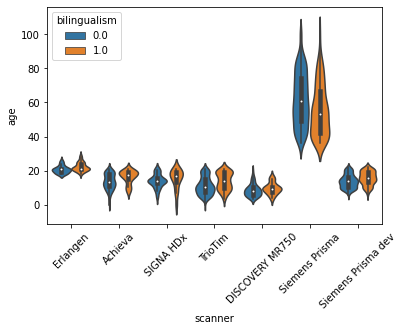

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.violinplot(x="scanner", y="age", hue='bilingualism', data=df_sort)
plt.xticks(rotation=45)
# plt.bar(df_sort['scanner'], df_sort['age'])
plt.show()

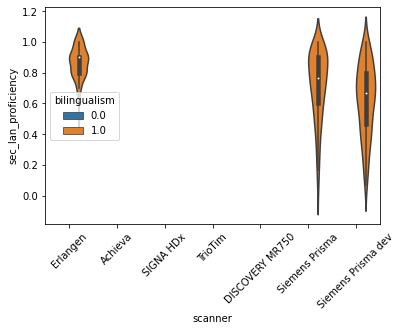

In [56]:
sns.violinplot(x="scanner", y="sec_lan_proficiency", hue='bilingualism', data=df_sort)
plt.xticks(rotation=45)
# plt.bar(df_sort['scanner'], df_sort['age'])
plt.show()

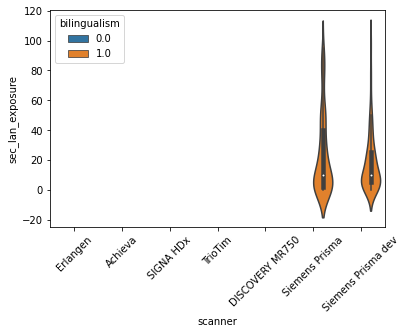

In [57]:
sns.violinplot(x="scanner", y="sec_lan_exposure", hue='bilingualism', data=df_sort)
plt.xticks(rotation=45)
# plt.bar(df_sort['scanner'], df_sort['age'])
plt.show()

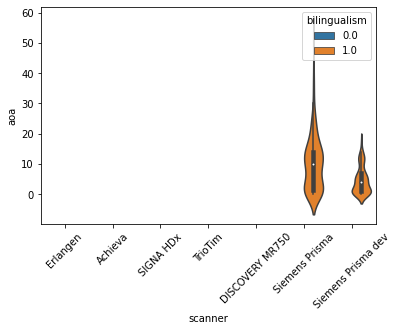

In [58]:
sns.violinplot(x="scanner", y="aoa", hue='bilingualism', data=df_sort)
plt.xticks(rotation=45)
# plt.bar(df_sort['scanner'], df_sort['age'])
plt.show()

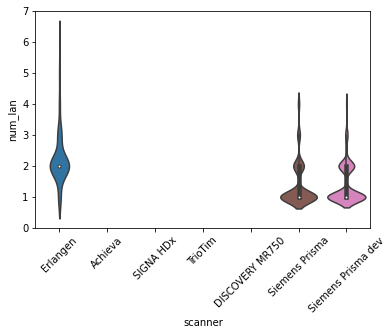

In [59]:
sns.violinplot(x="scanner", y="num_lan", data=df_sort)
plt.xticks(rotation=45)
# plt.bar(df_sort['scanner'], df_sort['age'])
plt.show()

In [60]:
pd.crosstab(df_sort['scanner'], df_sort['sex'])

sex,F,M
scanner,,
Achieva,86,91
DISCOVERY MR750,62,50
Erlangen,51,41
SIGNA HDx,47,58
Siemens Prisma,406,318
Siemens Prisma dev,309,262
TrioTim,168,188


In [61]:
pd.crosstab(df_sort['scanner'], df_sort['aoa_group'])

aoa_group,EB,LB
scanner,,
Erlangen,27,32
Siemens Prisma,126,75
Siemens Prisma dev,173,12


### aoa and aoa_group

In [62]:
aoa_rdm = model_rdms['aoa']
aoagroup_rdm = model_rdms['aoa_group']

KeyError: 'aoa'

In [37]:
common_idx = np.intersect1d(model_idxs['aoa'], model_idxs['aoa_group'])

In [38]:
indexes = np.where(np.in1d(model_idxs['aoa_group'], common_idx))[0]

In [39]:
corr = scipy.stats.stats.kendalltau
corr(get_triu(model_rdms['aoa']),get_triu(slice_cmat(model_rdms['aoa_group'], indexes))) 

KendalltauResult(correlation=0.5408876585791225, pvalue=0.0)

### all the predictors correlation

In [73]:
pred = df_sort[['sec_lan_proficiency','sec_lan_exposure','aoa','num_lan','age']]

In [74]:
pred['aoa_group'] = df_sort['aoa_group'].astype('category').cat.codes
pred['sex'] = df_sort['sex'].astype('category').cat.codes

<ipython-input-74-4f3cd44fb178>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['aoa_group'] = df_sort['aoa_group'].astype('category').cat.codes
<ipython-input-74-4f3cd44fb178>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred['sex'] = df_sort['sex'].astype('category').cat.codes


In [75]:
pred_matrix = pred.corr()

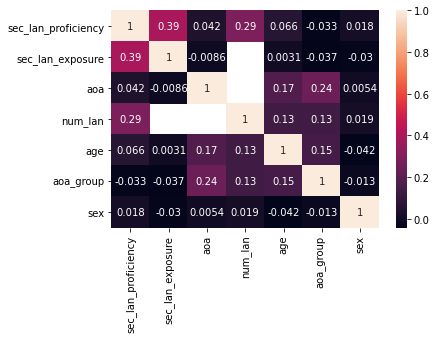

In [76]:
sns.heatmap(pred_matrix, annot=True)

In [77]:
from scipy.stats import pearsonr
import numpy as np
rho = pred.corr()
pval = pred.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

,sec_lan_proficiency,sec_lan_exposure,aoa,num_lan,age,aoa_group,sex
sec_lan_proficiency,1.0***,0.39***,0.04,0.29*,0.07,-0.03,0.02
sec_lan_exposure,0.39***,1.0***,-0.01,nan,0.0,-0.04,-0.03
aoa,0.04,-0.01,1.0***,nan,0.17***,0.24***,0.01
num_lan,0.29*,nan,nan,1.0***,0.13,0.13,0.02
age,0.07,0.0,0.17***,0.13,1.0***,0.15***,-0.04
aoa_group,-0.03,-0.04,0.24***,0.13,0.15***,1.0***,-0.01
sex,0.02,-0.03,0.01,0.02,-0.04,-0.01,1.0***


### PCA analysis

In [88]:
len(pred.dropna(subset=['num_lan']))
len(pred.dropna(subset=['sec_lan_exposure']))
len(pred.dropna(subset=['aoa']))
len(pred.dropna(subset=['sec_lan_proficiency']))

pred_drop = pred[['sec_lan_proficiency', 'sec_lan_exposure', 'aoa', 'aoa_group', 'age']].dropna()

In [89]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(pred_drop)

In [90]:
pca.explained_variance_ratio_

array([9.03554094e-01, 5.09028636e-02, 4.55264778e-02, 1.26835061e-05,
       3.88081633e-06])

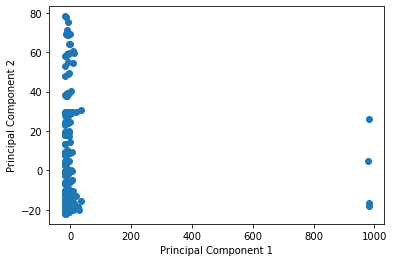

In [91]:
plt.scatter(principalComponents[:, 0], principalComponents[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


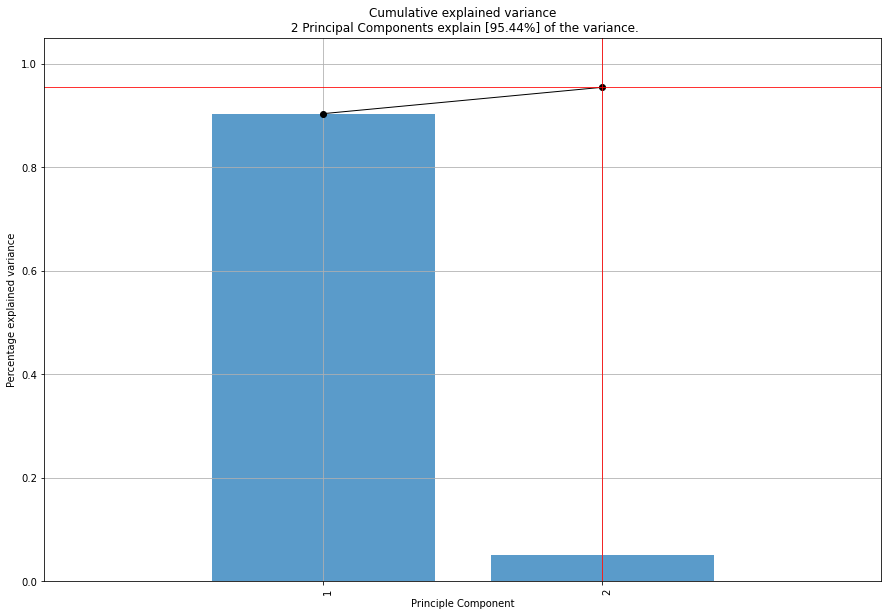

<Figure size 432x288 with 0 Axes>

In [94]:
from pca import pca

# Or reduce the data towards 2 PCs
model = pca(n_components=2)

# Fit transform
results = model.fit_transform(pred_drop)

# Plot explained variance
fig, ax = model.plot()

[pca] >Plotting: 90it [00:00, 894.98it/s]

[pca] >Plot PC1 vs PC2 with loadings.


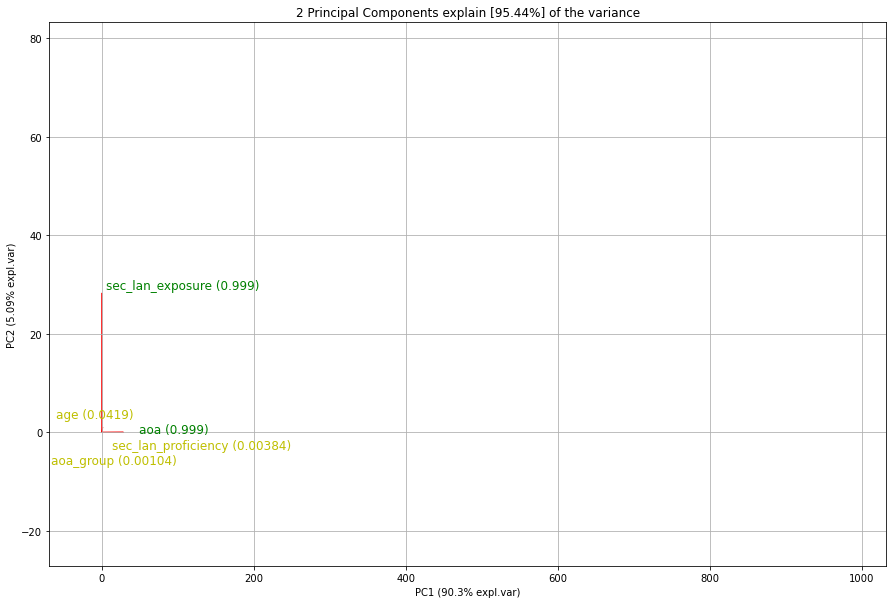

In [102]:
# Make biplot with the number of features
fig, ax = model.biplot(cmap=None, label=False, legend=False, n_feat=5)

<function matplotlib.pyplot.show(*args, **kw)>

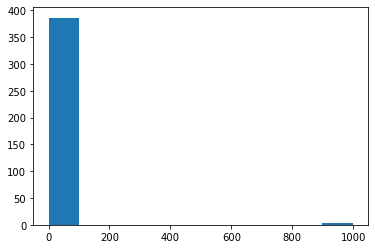

In [103]:
plt.hist(pred.aoa)
plt.show

In [106]:
pred_drop = pred_drop[pred_drop.aoa.values < 200]

<function matplotlib.pyplot.show(*args, **kw)>

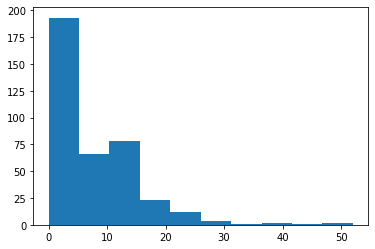

In [107]:
plt.hist(pred_drop.aoa)
plt.show